# Importing Libs

In [1]:
# ML
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    Normalizer,
    OneHotEncoder,
    LabelEncoder,
    OrdinalEncoder
)

from sklearn.pipeline import Pipeline
from sklearn.base import clone

from sklearn.metrics import (
    accuracy_score,
    mean_squared_error,
    r2_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    balanced_accuracy_score,
    average_precision_score,
    roc_auc_score,
    brier_score_loss
)
from sklearn.model_selection import (
    TimeSeriesSplit
)

import optuna

import sklearn

# DL
import os, faulthandler
faulthandler.enable()

os.environ["OMP_NUM_THREADS"] = "1"
# os.environ["VECLIB_MAXIMUM_THREADS"] = "4"
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F


# TA tools
import ta

# basic
import numpy as np
import pandas as pd

# visualize
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, display

from tqdm.notebook import tqdm

import logging, time

# options
pd.set_option('display.max_columns', None)

# versions used
print(f"pandas=={pd.__version__}")
print(f"numpy=={np.__version__}")
print(f"sklearn=={sklearn.__version__}")
print(f"torch=={torch.__version__}")
print(f"optuna=={optuna.__version__}")

pandas==2.2.3
numpy==2.2.4
sklearn==1.6.1
torch==2.9.0.dev20250816
optuna==4.4.0


# Data

We have loaded data in a `stock_loader_experiments.ipynb` notebook  using our cctx library.

In [2]:
# let's take some tickers data
df_base = pd.read_parquet('data/raw_data/BTC_USD_since_2025_03_01.parquet')

# converting and deleting some columns
df_base['ts'] = pd.to_datetime(df_base['ts'])

df_base.sample(1)

,ts,Open,High,Low,Close,Volume
5152,2025-03-04 13:52:00+00:00,82929.05,82967.45,82842.0,82926.02,58.11793


There is a problem with consistency in data (i.e. some minutes are missed), so let's check it

In [3]:
def check_minute_difference(datetime1, datetime2):
  difference = datetime1 - datetime2
  return difference.total_seconds() == 60.0

In [4]:
for i in range(df_base.shape[0]):
    if i == df_base.shape[0] - 1:
        break
    if not check_minute_difference(df_base['ts'].iloc[i+1], df_base['ts'].iloc[i]):
        print(i)

So on real-world implementation we would want to create a training dataset manually with realtime data, for now we will treat each row as a single minute

# Classic DL experiments

Before using any DL approaches we want to build a baseline classic ML approach which will work as a guideline when looking at alternatives which DL techniques that can may or not help us

In [5]:
time_periods = [5, 10, 15]
percentage_changes = [0.1, 0.15, 0.2]

## Features

Let's add indicators that can be used by several approaches to enhance its results

### Classical indicators

In [6]:
def add_basic_feats(df):
    df = df.copy()
    df['HL_RANGE'] = (df['High'] - df['Low']) / df['Close']
    df['LOG_VOL'] = np.log1p(df['Volume'])
    lr = np.log(df['Close']).diff()
    for period in time_periods:
        df['RV_{}M'.format(period)] = np.sqrt(lr.pow(2).rolling(period, min_periods=period).sum())
    # Time of day
    # mins = df.index.hour * 60 + df.index.minute
    # df['tod_sin'] = np.sin(2*np.pi*mins/ (24*60))
    # df['tod_cos'] = np.cos(2*np.pi*mins/ (24*60))
    return df

df_base = add_basic_feats(df_base)

#### SMA & EMA

Moving Averages (SMA & EMA): The Simple Moving Average (SMA) and Exponential Moving Average (EMA) smooth out price data to reveal the underlying trend. They are fundamental trend-following indicators. Intraday traders often plot short-term moving averages (e.g. 5-minute or 15-minute SMA) to identify trend direction. A common strategy is the moving average crossover – for example, if a short-term EMA crosses above a longer-term EMA, it generates a buy signal (anticipating upward momentum). These crossovers have been used on MOEX stocks to catch emerging trends. In one study, various SMA lengths were tested in an intraday RSI strategy; shorter-period SMAs improved profitability during downtrends, indicating the importance of choosing an appropriate moving average length for the market condition ￼. Overall, moving averages help traders filter out noise and decide if momentum favors long or short positions. They are also components of other indicators (for instance, the MACD uses EMA calculations).

In [7]:
df_base['SMA_9'] = ta.trend.sma_indicator(df_base['Close'], 9)
df_base['SMA_10'] = ta.trend.sma_indicator(df_base['Close'], 10)
df_base['SMA_21'] = ta.trend.sma_indicator(df_base['Close'], 21)

df_base['EMA_9'] = ta.trend.ema_indicator(df_base['Close'], 9)
df_base['EMA_10'] = ta.trend.ema_indicator(df_base['Close'], 10)
df_base['EMA_21'] = ta.trend.ema_indicator(df_base['Close'], 21)

#### RSI

Relative Strength Index (RSI): RSI is a popular momentum oscillator that measures the magnitude of recent price gains vs. losses on a 0–100 scale ￼. It is used to identify overbought conditions (RSI above 70, indicating prices may have risen too fast) and oversold conditions (RSI below 10) ￼. RSI has shown its value in many markets; for example, studies on emerging markets found that RSI signals can generate accurate buy/sell prompts and even produce abnormal returns ￼. Traders often use RSI on intraday MOEX charts to anticipate reversals – if a stock’s RSI dips below 10, it may be poised for a bounce (buy signal), whereas an RSI above 70 could warn of an upcoming pullback (sell signal). Importantly, combining RSI with other indicators strengthens its effectiveness. Research suggests the best results come from using RSI alongside complementary signals like moving averages ￼, which confirm the trend context. For instance, if the RSI gives an oversold reading and at the same time the price is bouncing off a key moving average support, the confluence increases confidence in a buy trade. This indicator’s ubiquity among traders makes it a self-fulfilling tool at times – many MOEX trading algorithms monitor RSI levels, contributing to short-term support and resistance around those threshold values.

In [8]:
df_base['RSI_9'] = ta.momentum.rsi(df_base['Close'], 9)
df_base['RSI_11'] = ta.momentum.rsi(df_base['Close'], 11)

#### MACD

Moving Average Convergence Divergence (MACD): MACD is another momentum/trend indicator that calculates the difference between two EMAs and a signal line (the EMA of that difference). It oscillates above and below zero, highlighting changes in trend momentum. A positive MACD indicates upward momentum, while a negative MACD indicates downward momentum; the crossing of MACD above its signal line is a classic bullish signal (and vice versa for bearish). MACD is widely favored for intraday trading because it combines aspects of trend following and momentum in one indicator. Traders on the MOEX use MACD histograms and crossovers to spot trend reversals or trend strength changes in stocks or the MOEX index itself. A strong use case is pairing MACD with RSI: one popular strategy requires MACD line crossing above the signal and RSI coming out of oversold territory to trigger a buy, capturing both trend and momentum confirmation. In fact, backtests of strategies combining MACD and RSI have shown high success rates – one such strategy yielded about a 73% win rate over hundreds of trades, with an average 0.88% gain per trade ￼. This demonstrates how MACD, especially in combination with RSI, can be a powerful tool for timing intraday entries and exits.

In [9]:

# the best parameters for intraday trading mentioned here -> https://market-bulls.com/macd-indicator-trading-strategies/
macd = ta.trend.MACD(
    close=df_base['Close'],
    window_slow=17,
    window_fast=8,
    window_sign=9
)

df_base['MACD'] = macd.macd()
df_base['MACD_Signal'] = macd.macd_signal()
df_base['MACD_Hist'] = macd.macd_diff()

#### Bollinger Bands

Bollinger Bands: Bollinger Bands are a volatility indicator consisting of a moving average (typically 20-period SMA) and upper/lower bands set a certain number of standard deviations away (often 2σ). The bands widen when volatility increases and contract when volatility drops. Intraday traders use Bollinger Bands to identify potential breakouts or mean-reversion opportunities. For example, when price repeatedly touches the upper band, the market may be overextended to the upside (potential reversal or short setup), whereas a sharp move outside the bands could signal an emerging breakout with increased volatility. In high-frequency trading contexts, Bollinger Bands help gauge if current price swings are outside normal volatility ranges ￼. On the MOEX, which can experience sudden moves due to news or low liquidity in certain stocks, Bollinger Band signals are quite useful. A common strategy is to fade extreme moves – if a Russian stock’s price spikes well above the upper band on an intraday chart, traders might short expecting a pullback toward the mean. Conversely, touching the lower band after a steady decline could present a buy-the-dip opportunity. However, it’s important to confirm with other indicators (Bollinger Band breakouts combined with volume spikes or momentum divergences provide stronger evidence of a true breakout or reversal).

In [10]:
# the best parameters for intraday trading mentioned here -> https://www.stockdaddy.in/blog/bollinger-bands-strategy
bb = ta.volatility.BollingerBands(close=df_base['Close'], window=20, window_dev=2)

df_base['BB_mavg'] = bb.bollinger_mavg()
df_base['BB_hband'] = bb.bollinger_hband()
df_base['BB_lband'] = bb.bollinger_lband()
df_base['BB_width'] = bb.bollinger_wband()
df_base['BB_pband'] = bb.bollinger_pband()
df_base['BB_hband_ind'] = bb.bollinger_hband_indicator()
df_base['BB_lband_ind'] = bb.bollinger_lband_indicator()

#### OBV

On-Balance Volume (OBV) and Volume Indicators: Volume-based indicators play a crucial role in validating price movements. OBV is a simple yet powerful indicator that accumulates volume, adding volume on up days and subtracting on down days ￼. It effectively measures buying and selling pressure. Rising OBV indicates that volume is flowing into an asset (buyers are dominant), often foreshadowing an upward breakout, while falling OBV signals distribution (selling pressure) ￼. Traders use OBV intraday to confirm trends: if price is climbing and OBV is also steadily rising, it suggests the uptrend is backed by strong volume (and likely to continue). If price makes new highs but OBV fails to reach a new high (a bearish divergence), it can warn that the rally is losing support and may reverse. On MOEX, where certain stocks can have erratic volume, OBV helps filter false price moves. For instance, a sudden price jump on low volume is treated suspiciously by algo-traders – if OBV doesn’t confirm the move, they may avoid the bait. Other volume indicators like the Volume Weighted Average Price (VWAP) are also popular intraday tools (VWAP is often used by institutional traders as a benchmark; prices above VWAP indicate an uptrend with strength, below VWAP indicates a downtrend). In general, volume indicators complement price-based indicators by adding the dimension of market participation, which is key in the relatively smaller and sometimes volatile Russian market. Combining volume signals with price signals is a widely recommended practice – for example, a breakout above a resistance level is far more convincing if accompanied by a surge in OBV or volume, confirming that big players are driving the move ￼.

In [11]:
obv = ta.volume.OnBalanceVolumeIndicator(
    close=df_base['Close'],
    volume=df_base['Volume']
)

df_base['OBV'] = obv.on_balance_volume()

####  Stochastic oscilator

The Stochastic Oscillator (similar to RSI, used to indicate overbought/oversold levels based on recent closing prices relative to price range) is often used on short time frames for MOEX stocks to pick turning points.

In [12]:
stoch = ta.momentum.StochasticOscillator(
    high=df_base['High'],
    low=df_base['Low'],
    close=df_base['Close'],
    window=9,
    smooth_window=3
)

df_base['Stoch_K'] = stoch.stoch()
df_base['Stoch_D'] = stoch.stoch_signal()

#### Commodity Channel Index

The Commodity Channel Index (CCI) is another momentum indicator highlighted in studies for trend detection ￼.

In [13]:
cci = ta.trend.CCIIndicator(
    high=df_base['High'],
    low=df_base['Low'],
    close=df_base['Close'],
    window=14,
    constant=0.010 # more sensitive
)

df_base['CCI'] = cci.cci()

#### Average True Range

Average True Range (ATR) is commonly monitored to gauge intraday volatility – for example, a widening ATR on a stock like Sberbank might imply the next price swing could be larger than usual, prompting traders to adjust stop-loss distances.

In [14]:
atr = ta.volatility.AverageTrueRange(
    high=df_base['High'],
    low=df_base['Low'],
    close=df_base['Close'],
    window=9
)

df_base['ATR_9'] = atr.average_true_range()

#### Ichimoku Cloud

Ichimoku Cloud (a comprehensive trend system) is sometimes applied to index futures or highly liquid Russian equities to map support/resistance and trend momentum at a glance.

In [15]:
ichimoku = ta.trend.IchimokuIndicator(
    high=df_base['High'],
    low=df_base['Low'],
    window1=9,
    window2=18,
    window3=34,
    visual=False
)

df_base['Ichimoku_A'] = ichimoku.ichimoku_a()
df_base['Ichimoku_B'] = ichimoku.ichimoku_b()
df_base['Ichimoku_Base'] = ichimoku.ichimoku_base_line()
df_base['Ichimoku_Conversion'] = ichimoku.ichimoku_conversion_line()

### Summing up

In [16]:
indicators = df_base.columns[df_base.columns.str.contains('SMA|EMA|RSI|MACD|BB|Stoch|CCI|ATR|Ichimoku|OBV|Volume|Open|Close|High|Low')]

In [17]:
df_base

,ts,Open,High,Low,Close,Volume,HL_RANGE,LOG_VOL,RV_5M,RV_10M,RV_15M,SMA_9,SMA_10,SMA_21,EMA_9,EMA_10,EMA_21,RSI_9,RSI_11,MACD,MACD_Signal,MACD_Hist,BB_mavg,BB_hband,BB_lband,BB_width,BB_pband,BB_hband_ind,BB_lband_ind,OBV,Stoch_K,Stoch_D,CCI,ATR_9,Ichimoku_A,Ichimoku_B,Ichimoku_Base,Ichimoku_Conversion
0,2025-03-01 00:00:00+00:00,84349.95,84390.05,84324.42,84338.54,14.42832,7.781733e-04,2.736205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,14.428320,NaN,NaN,NaN,0.000000,NaN,84357.235,NaN,NaN
1,2025-03-01 00:01:00+00:00,84337.70,84337.70,84269.50,84274.88,9.99548,8.092566e-04,2.397484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,4.432840,NaN,NaN,NaN,0.000000,NaN,84329.775,NaN,NaN
2,2025-03-01 00:02:00+00:00,84274.88,84282.60,84266.01,84266.02,5.58371,1.968765e-04,1.884598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,-1.150870,NaN,NaN,NaN,0.000000,NaN,84328.030,NaN,NaN
3,2025-03-01 00:03:00+00:00,84266.01,84300.00,84257.15,84299.99,4.66581,5.083037e-04,1.734450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,3.514940,NaN,NaN,NaN,0.000000,NaN,84323.600,NaN,NaN
4,2025-03-01 00:04:00+00:00,84299.99,84346.10,84295.74,84295.75,5.14888,5.974204e-04,1.816270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,-1.633940,NaN,NaN,NaN,0.000000,NaN,84323.600,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243048,2025-08-16 18:48:00+00:00,117699.99,117700.00,117699.99,117699.99,0.30569,8.496177e-08,0.266732,0.000343,0.000362,0.000380,117677.673333,117678.474,117686.643333,117683.140376,117683.146412,117686.587855,60.413835,57.810797,-1.811754,-5.102110,3.290357,117686.2010,117713.121243,117659.280757,0.045749,0.756108,0.0,0.0,36089.681254,99.985727,87.283138,130.162273,10.485465,117664.97,117693.500,117664.97,117664.97
243049,2025-08-16 18:49:00+00:00,117700.00,117700.00,117699.99,117699.99,0.71471,8.496177e-08,0.539244,0.000320,0.000348,0.000363,117679.894444,117679.905,117686.857619,117686.510301,117686.208883,117687.806232,60.413835,57.810797,0.243478,-4.032993,4.276471,117686.4260,117713.725582,117659.126418,0.046394,0.748429,0.0,0.0,36090.395964,99.985727,99.985727,130.166626,9.321524,117664.97,117693.500,117664.97,117664.97
243050,2025-08-16 18:50:00+00:00,117699.99,117700.00,117699.99,117699.99,0.60947,8.496177e-08,0.475905,0.000304,0.000345,0.000363,117682.115556,117681.904,117687.071905,117689.206241,117688.714541,117688.913847,60.413835,57.810797,1.658368,-2.894721,4.553088,117686.8255,117714.668117,117658.982883,0.047316,0.736409,0.0,0.0,36091.005434,99.985727,99.985727,127.976246,8.286911,117664.97,117693.430,117664.97,117664.97
243051,2025-08-16 18:51:00+00:00,117700.00,117700.00,117659.49,117659.50,3.46699,3.442986e-04,1.496715,0.000420,0.000487,0.000499,117679.837778,117679.854,117685.524286,117683.264993,117683.402806,117686.239861,35.173552,36.797245,-1.903274,-2.696431,0.793158,117685.4765,117715.762550,117655.190450,0.051469,0.071147,0.0,0.0,36087.538444,42.192407,80.721287,-73.363108,11.867254,117664.97,117693.430,117664.97,117664.97


## Building experiments

Let's now define several types of values to predict, we will try to solve to types of tasks: classification and regression and in final sollution we will combine them together.

- Classification: we want to understand whether the price will rise or fall by $x\%$ in a period of $y\%$ hours or days
- Regression: we want to understand what will be the price of a stock in $y\%$ hours or days, or we want to predict several prices for several corresponding time stamps

In [18]:
time_periods = [5, 10, 15]
percentage_changes = [0.1, 0.15, 0.2]

In [19]:
for lag in time_periods:
    df_base[f'Close_in_{lag}_min'] = df_base['Close'].shift(periods=-1 * lag)

for lag in time_periods:
    df_base[f'Ret_in_{lag}m'] = (df_base[f'Close_in_{lag}_min'] - df_base['Close']) / df_base['Close']

df_base.dropna(inplace=True)

for lag in time_periods:
    df_base[f'Target_cls_simple_{lag}_min'] = df_base[f'Close_in_{lag}_min'] > df_base['Close']
    df_base[f'Target_cls_simple_{lag}_min'] = df_base[f'Target_cls_simple_{lag}_min'].astype(int)
    for change in percentage_changes:
        df_base[f'Target_cls_{change}%_{lag}_min'] = df_base[f'Close_in_{lag}_min'] >= df_base['Close'] * (1 + change / 100)
        df_base[f'Target_cls_{change}%_{lag}_min'] = df_base[f'Target_cls_{change}%_{lag}_min'].astype(int)

In [20]:
def lag_stack(df, cols, L: int):
    # Lags [t, t-1, ..., t-(L-1)]
    parts = []
    for i in range(L):
        parts.append(df[cols].shift(i).add_suffix(f'_t-{i}'))
    return pd.concat(parts, axis=1)

In [21]:
base_cols = [
    'Close', 'HL_RANGE', 'LOG_VOL', 'RV_15M',
    'SMA_9', 'EMA_9', 'RSI_9', 'MACD', 'MACD_Signal',
    'BB_pband', 'BB_width', 'ATR_9', 'CCI', 'Stoch_K', 'Stoch_D'
    # 'Ichimoku_A', 'Ichimoku_B'
]
L = 8  # number of "ticks behind" to include
lagged = lag_stack(df_base, base_cols, L).astype('float32')

In [22]:
# purged walk-forward split
def walk_forward_splits_row_embargo(index, n_splits=5, embargo_minutes=60, bars_per_minute=1):
    tss = TimeSeriesSplit(n_splits=n_splits)
    embargo_rows = int(embargo_minutes * bars_per_minute)
    for tr, te in tss.split(range(len(index))):
        tr, te = np.asarray(tr), np.asarray(te)
        cutoff_pos = max(0, te[0] - embargo_rows)
        keep = tr <= cutoff_pos
        yield tr[keep], te


### Regression experiments (with DL)

In [23]:
def prepare_frame_ret(df, feature_cols, horizons):
    keep = feature_cols + [f'Ret_in_{h}m' for h in horizons]
    df2 = df[keep].dropna().copy()  # drop rows missing futures/indicators
    X = df2[feature_cols].astype('float32').values     # [T, F]
    Y = df2[[f'Ret_in_{h}m' for h in horizons]].astype('float32').values  # [T, H]
    idx = df2.index
    return X, Y, idx

def prepare_frame_close(df, feature_cols, horizons):
    keep = feature_cols + [f'Close_in_{h}_min' for h in horizons]
    df2 = df[keep].dropna().copy()  # drop rows missing futures/indicators
    X = df2[feature_cols].astype('float32').values     # [T, F]
    Y = df2[[f'Close_in_{h}_min' for h in horizons]].astype('float32').values  # [T, H]
    idx = df2.index
    return X, Y, idx

In [24]:
class SeqDataset(Dataset):
    def __init__(self, X, Y, end_indices, L, stride=1):
        self.X, self.Y, self.L = X, Y, L
        # windows end at these positions (already filtered to train/test)
        self.ends = np.array(end_indices)[::stride]

    def __len__(self): return len(self.ends)
    def __getitem__(self, i):
        end = self.ends[i]
        start = end - self.L + 1
        x = self.X[start:end+1]              # [L, F]
        y = self.Y[end]                      # [H]
        return torch.from_numpy(x), torch.from_numpy(y)

def build_seq_loaders_by_index(
    X, Y, L, train_idx, test_idx, *,
    val_ratio=0.1,
    batch=64,
    train_stride=4,
    num_workers=0,
    pin_memory=False,
):
    valid_ends = np.arange(L-1, len(X))             # windows must have L steps
    train_ends = valid_ends[np.isin(valid_ends, train_idx)]
    test_ends  = valid_ends[np.isin(valid_ends,  test_idx)]

    # time-consistent split: last chunk of train_ends is validation
    n_val = max(1, int(len(train_ends) * val_ratio))
    val_ends   = train_ends[-n_val:]
    true_tr_ends = train_ends[:-n_val]

    # thin training windows if dataset is huge
    if train_stride and train_stride > 1:
        true_tr_ends = true_tr_ends[::train_stride]

    ds_tr = SeqDataset(X, Y, true_tr_ends, L)
    ds_va = SeqDataset(X, Y, val_ends,     L)
    ds_te = SeqDataset(X, Y, test_ends,    L)

    dl_tr = DataLoader(ds_tr, batch_size=batch, shuffle=True,  drop_last=True,
                       num_workers=num_workers, persistent_workers=False, pin_memory=pin_memory)
    dl_va = DataLoader(ds_va, batch_size=batch, shuffle=False, drop_last=False,
                       num_workers=num_workers, persistent_workers=False, pin_memory=pin_memory)
    dl_te = DataLoader(ds_te, batch_size=batch, shuffle=False, drop_last=False,
                       num_workers=num_workers, persistent_workers=False, pin_memory=pin_memory)
    return dl_tr, dl_va, dl_te

In [25]:
def metrics_reg(y_true, y_pred, eps=1e-8):
    # y_*: [N, H]
    mae  = (y_true - y_pred).abs().mean().item()
    rmse = torch.sqrt(((y_true - y_pred)**2).mean()).item()
    mape = ( (y_true.abs() + eps) - (y_true - y_pred).abs() ).abs()  # avoid div-by-0; custom robust MAPE below
    mape = ( (y_true - y_pred).abs() / (y_true.abs() + eps) ).mean().item()
    # optional directional accuracy
    dir_acc = (torch.sign(y_true) == torch.sign(y_pred)).float().mean().item()
    return dict(mae=mae, rmse=rmse, mape=mape, dir_acc=dir_acc)

def train_one_epoch(model, dl, opt, device, clip=1.0):
    model.train(); tot=0.
    for x, y in dl:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        yhat = model(x)
        loss = F.smooth_l1_loss(yhat, y)
        loss.backward()
        if clip: nn.utils.clip_grad_norm_(model.parameters(), clip)
        opt.step()
        tot += loss.item() * x.size(0)
    return tot / len(dl.dataset)

@torch.no_grad()
def eval_epoch(model, dl, device):
    model.eval()
    tot = 0.0
    yh = []
    yt = []
    for x, y in dl:
        x, y = x.to(device), y.to(device)
        yhat = model(x)
        loss = F.smooth_l1_loss(yhat, y, reduction='sum')
        tot += loss.item()
        yh.append(yhat.cpu()); yt.append(y.cpu())
    if len(yh) == 0:  # guard: empty loader edge-case
        return {'loss': float('nan'), 'mae': float('nan'), 'rmse': float('nan'),
                'mape': float('nan'), 'dir_acc': float('nan')}, torch.empty(0), torch.empty(0)
    yh, yt = torch.cat(yh), torch.cat(yt)
    m = metrics_reg(yt, yh)
    m['loss'] = tot / len(dl.dataset)
    return m, yh, yt

def fit_model(model, dl_tr, dl_va, device, epochs=50, lr=1e-3, wd=1e-4, patience=6, tag=""):
    model.to(device)
    opt = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    best = (float('inf'), None); noimp=0
    pbar = tqdm(range(1, epochs+1), desc=f"{tag} training", leave=False)
    for ep in pbar:
        tr_loss = train_one_epoch(model, dl_tr, opt, device)
        va_m, _, _ = eval_epoch(model, dl_va, device)
        pbar.set_postfix(loss=tr_loss, val=va_m['loss'], mae=va_m['mae'])
        if va_m['loss'] < best[0]:
            best = (va_m['loss'], {k:v.clone() for k,v in model.state_dict().items()})
            noimp=0
        else:
            noimp += 1
            if noimp >= patience: break
    # load best
    if best[1] is not None: model.load_state_dict(best[1])
    return model

#### TCN

In [26]:
class Chomp1d(nn.Module):
    def __init__(self, chomp): super().__init__(); self.chomp = chomp
    def forward(self, x): return x[:, :, :-self.chomp].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, dilation, dropout):
        super().__init__()
        padding = (kernel_size-1) * dilation
        self.net = nn.Sequential(
            nn.utils.weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           padding=padding, dilation=dilation)),
            Chomp1d(padding), nn.ReLU(), nn.Dropout(dropout),
            nn.utils.weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           padding=padding, dilation=dilation)),
            Chomp1d(padding), nn.ReLU(), nn.Dropout(dropout),
        )
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else nn.Identity()
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.net(x)
        res = self.downsample(x)
        return self.relu(out + res)

class TCNRegressor(nn.Module):
    def __init__(self, in_feats, horizons, channels=(64,64,64), k=5, dropout=0.1):
        super().__init__()
        layers, c_in = [], in_feats
        for i, c_out in enumerate(channels):
            layers += [TemporalBlock(c_in, c_out, kernel_size=k, dilation=2**i, dropout=dropout)]
            c_in = c_out
        self.tcn = nn.Sequential(*layers)
        self.head = nn.Sequential(nn.Flatten(start_dim=1), nn.Linear(c_in, 128), nn.ReLU(), nn.Linear(128, horizons))
    def forward(self, x):           # x: [B, L, F]
        x = x.transpose(1,2)        # -> [B, F, L]
        z = self.tcn(x)             # -> [B, C, L]
        last = z[:, :, -1]          # last time step features
        return self.head(last)      # [B, H]

In [27]:
def est_batch_mb(B, L, F, channels=(32,32)):
    # very rough: inputs + activations for TCN
    x = B*L*F*4
    acts = B*L*sum(channels)*4
    return (x + acts) / (1024**2)

X_raw, Y_raw, idx = prepare_frame_ret(df_base, base_cols, time_periods)
BATCH = 16; L = 128; S = X_raw.shape[1]
print(f"~est per-batch RAM: {est_batch_mb(BATCH, L, S, channels=(32,32)):.1f} MB")

~est per-batch RAM: 0.6 MB


In [28]:
def run_tcn_seq_experiment_ret(df, feature_cols, horizons, splits, L=128,
                       batch=256, stride=2,
                       device='cuda' if torch.cuda.is_available() else 'cpu'):
    X_raw, Y_raw, idx = prepare_frame_ret(df, feature_cols, horizons)
    X_raw = X_raw.astype('float32'); Y_raw = Y_raw.astype('float32')

    fold_rows = []
    for k, (tr_idx, te_idx) in enumerate(tqdm(splits, desc="TCN folds"), 1):
        # scale on train only
        scaler = StandardScaler().fit(X_raw[tr_idx])
        Xs = scaler.transform(X_raw).astype('float32')

        # build loaders by index (train/val/test)
        dl_tr, dl_va, dl_te = build_seq_loaders_by_index(
            Xs, Y_raw, L, tr_idx, te_idx,
            val_ratio=0.10, batch=batch, train_stride=stride,
            num_workers=0, pin_memory=False
        )

        # skip fold if no samples (can happen if test chunk < L)
        if len(dl_tr.dataset) == 0 or len(dl_va.dataset) == 0 or len(dl_te.dataset) == 0:
            print(f"[Fold {k}] Skipped (insufficient windows).")
            continue

        in_feats = Xs.shape[1]; H = len(horizons)
        model = TCNRegressor(in_feats, H, channels=(16, 16), k=2, dropout=0.1)

        model = fit_model(model, dl_tr, dl_va, device,
                          epochs=60, lr=1e-3, wd=1e-4, patience=8, tag=f"TCN fold {k}")

        m, yhat, ytrue = eval_epoch(model, dl_te, device)
        m['fold'] = k
        fold_rows.append(m)

        # (optional) free memory
        del Xs, dl_tr, dl_va, dl_te, model, yhat, ytrue
        import gc; gc.collect()
    return pd.DataFrame(fold_rows)

def run_tcn_seq_experiment_close(df, feature_cols, horizons, splits, L=128,
                       batch=256, stride=2,
                       device='cuda' if torch.cuda.is_available() else 'cpu'):
    X_raw, Y_raw, idx = prepare_frame_close(df, feature_cols, horizons)
    X_raw = X_raw.astype('float32'); Y_raw = Y_raw.astype('float32')

    fold_rows = []
    for k, (tr_idx, te_idx) in enumerate(tqdm(splits, desc="TCN folds"), 1):
        # scale on train only
        scaler = StandardScaler().fit(X_raw[tr_idx])
        Xs = scaler.transform(X_raw).astype('float32')

        # build loaders by index (train/val/test)
        dl_tr, dl_va, dl_te = build_seq_loaders_by_index(
            Xs, Y_raw, L, tr_idx, te_idx,
            val_ratio=0.10, batch=batch, train_stride=stride,
            num_workers=0, pin_memory=False
        )

        # skip fold if no samples (can happen if test chunk < L)
        if len(dl_tr.dataset) == 0 or len(dl_va.dataset) == 0 or len(dl_te.dataset) == 0:
            print(f"[Fold {k}] Skipped (insufficient windows).")
            continue

        in_feats = Xs.shape[1]; H = len(horizons)
        model = TCNRegressor(in_feats, H, channels=(16, 16), k=2, dropout=0.1)

        model = fit_model(model, dl_tr, dl_va, device,
                          epochs=60, lr=1e-3, wd=1e-4, patience=8, tag=f"TCN fold {k}")

        m, yhat, ytrue = eval_epoch(model, dl_te, device)
        m['fold'] = k
        fold_rows.append(m)

        # (optional) free memory
        del Xs, dl_tr, dl_va, dl_te, model, yhat, ytrue
        import gc; gc.collect()
    return pd.DataFrame(fold_rows)

In [ ]:
embargo = max(time_periods)
splits = list(walk_forward_splits_row_embargo(df_base.index, n_splits=3, embargo_minutes=embargo))
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu'
tcn_ret_res = run_tcn_seq_experiment_ret(df_base, base_cols, time_periods, splits, device=DEVICE, L=128, batch=16, stride=2)

In [71]:
tcn_ret_res

,mae,rmse,mape,dir_acc,loss,fold
0,0.001137,0.001659,17.927216,0.489871,0.000004,1
1,0.000955,0.001408,42.578724,0.495419,0.000003,2
2,0.000943,0.001395,14.444373,0.500340,0.000003,3


In [ ]:
tcn_ret_close = run_tcn_seq_experiment_close(df_base, base_cols, time_periods, splits, device='cuda', L=128, batch=16, stride=2)

TCN folds:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


TCN fold 1 training:   0%|          | 0/60 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


TCN fold 2 training:   0%|          | 0/60 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


TCN fold 3 training:   0%|          | 0/60 [00:00<?, ?it/s]

In [ ]:
tcn_ret_close

#### GRU / LSTM

In [28]:
class GRU_RNNRegressor(nn.Module):
    def __init__(self, in_feats, horizons, hidden=128, layers=2, dropout=0.1):
        super().__init__()
        rnn = nn.GRU # single GRU as a base
        self.rnn = rnn(input_size=in_feats, hidden_size=hidden, num_layers=layers,
                       batch_first=True, dropout=dropout if layers>1 else 0.)
        self.head = nn.Sequential(nn.Linear(hidden, 128), nn.ReLU(), nn.Linear(128, horizons))
    def forward(self, x):           # [B, L, F]
        out, h = self.rnn(x)
        last = out[:, -1, :]        # last hidden
        return self.head(last)

class LSTM_RNNRegressor(nn.Module):
    def __init__(self, in_feats, horizons, hidden=128, layers=2, dropout=0.1):
        super().__init__()
        rnn = nn.LSTM # single LSTM as a base
        self.rnn = rnn(input_size=in_feats, hidden_size=hidden, num_layers=layers,
                       batch_first=True, dropout=dropout if layers>1 else 0.)
        self.head = nn.Sequential(nn.Linear(hidden, 128), nn.ReLU(), nn.Linear(128, horizons))
    def forward(self, x):           # [B, L, F]
        out, h = self.rnn(x)
        last = out[:, -1, :]        # last hidden
        return self.head(last)

In [52]:
def run_gru_seq_experiment(df, feature_cols, horizons, splits, L=128,
                       batch=256, stride=2,
                       device='cuda' if torch.cuda.is_available() else 'cpu'):
    X_raw, Y_raw, idx = prepare_frame(df, feature_cols, horizons)
    X_raw = X_raw.astype('float32'); Y_raw = Y_raw.astype('float32')

    fold_rows = []
    for k, (tr_idx, te_idx) in enumerate(tqdm(splits, desc="TCN folds"), 1):
        # scale on train only
        scaler = StandardScaler().fit(X_raw[tr_idx])
        Xs = scaler.transform(X_raw).astype('float32')

        # build loaders by index (train/val/test)
        dl_tr, dl_va, dl_te = build_seq_loaders_by_index(
            Xs, Y_raw, L, tr_idx, te_idx,
            val_ratio=0.10, batch=batch, train_stride=stride,
            num_workers=0, pin_memory=False
        )

        # skip fold if no samples (can happen if test chunk < L)
        if len(dl_tr.dataset) == 0 or len(dl_va.dataset) == 0 or len(dl_te.dataset) == 0:
            print(f"[Fold {k}] Skipped (insufficient windows).")
            continue

        in_feats = Xs.shape[1]; H = len(horizons)
        model = GRU_RNNRegressor(in_feats, H, hidden=128, layers=2, dropout=0.1)

        model = fit_model(model, dl_tr, dl_va, device,
                          epochs=60, lr=1e-3, wd=1e-4, patience=8, tag=f"TCN fold {k}")

        m, yhat, ytrue = eval_epoch(model, dl_te, device)
        m['fold'] = k
        fold_rows.append(m)

        # (optional) free memory
        del Xs, dl_tr, dl_va, dl_te, model, yhat, ytrue
        import gc; gc.collect()
    return pd.DataFrame(fold_rows)

def run_lstm_seq_experiment(df, feature_cols, horizons, splits, L=128,
                       batch=256, stride=2,
                       device='cuda' if torch.cuda.is_available() else 'cpu'):
    X_raw, Y_raw, idx = prepare_frame(df, feature_cols, horizons)
    X_raw = X_raw.astype('float32'); Y_raw = Y_raw.astype('float32')

    fold_rows = []
    for k, (tr_idx, te_idx) in enumerate(tqdm(splits, desc="TCN folds"), 1):
        # scale on train only
        scaler = StandardScaler().fit(X_raw[tr_idx])
        Xs = scaler.transform(X_raw).astype('float32')

        # build loaders by index (train/val/test)
        dl_tr, dl_va, dl_te = build_seq_loaders_by_index(
            Xs, Y_raw, L, tr_idx, te_idx,
            val_ratio=0.10, batch=batch, train_stride=stride,
            num_workers=0, pin_memory=False
        )

        # skip fold if no samples (can happen if test chunk < L)
        if len(dl_tr.dataset) == 0 or len(dl_va.dataset) == 0 or len(dl_te.dataset) == 0:
            print(f"[Fold {k}] Skipped (insufficient windows).")
            continue

        in_feats = Xs.shape[1]; H = len(horizons)
        model = LSTM_RNNRegressor(in_feats, H, hidden=128, layers=2, dropout=0.1)

        model = fit_model(model, dl_tr, dl_va, device,
                          epochs=60, lr=1e-3, wd=1e-4, patience=8, tag=f"TCN fold {k}")

        m, yhat, ytrue = eval_epoch(model, dl_te, device)
        m['fold'] = k
        fold_rows.append(m)

        # (optional) free memory
        del Xs, dl_tr, dl_va, dl_te, model, yhat, ytrue
        import gc; gc.collect()
    return pd.DataFrame(fold_rows)

In [53]:
embargo = max(time_periods)
splits = list(walk_forward_splits_row_embargo(df_base.index, n_splits=3, embargo_minutes=embargo))
gru_res = run_gru_seq_experiment(df_base, base_cols, time_periods, splits, device='cuda', L=128, batch=16, stride=2)

TCN folds:   0%|          | 0/3 [00:00<?, ?it/s]

TCN fold 1 training:   0%|          | 0/60 [00:00<?, ?it/s]

TCN fold 2 training:   0%|          | 0/60 [00:00<?, ?it/s]

TCN fold 3 training:   0%|          | 0/60 [00:00<?, ?it/s]

In [54]:
gru_res

,mae,rmse,mape,dir_acc,loss,fold
0,0.001137,0.001657,21.430820,0.504324,0.000004,1
1,0.000963,0.001414,55.676182,0.500401,0.000003,2
2,0.000943,0.001393,34.096535,0.500313,0.000003,3


In [55]:
embargo = max(time_periods)
splits = list(walk_forward_splits_row_embargo(df_base.index, n_splits=3, embargo_minutes=embargo))
lstm_res = run_lstm_seq_experiment(df_base, base_cols, time_periods, splits, device='cuda', L=128, batch=16, stride=2)

TCN folds:   0%|          | 0/3 [00:00<?, ?it/s]

TCN fold 1 training:   0%|          | 0/60 [00:00<?, ?it/s]

TCN fold 2 training:   0%|          | 0/60 [00:00<?, ?it/s]

TCN fold 3 training:   0%|          | 0/60 [00:00<?, ?it/s]

In [56]:
lstm_res

,mae,rmse,mape,dir_acc,loss,fold
0,0.001169,0.001686,28.220226,0.502601,0.000004,1
1,0.000953,0.001412,17.814837,0.504038,0.000003,2
2,0.000935,0.001385,12.094538,0.499084,0.000003,3


#### Simple transformer

### Visualizing regression experiments

In [58]:
def target_cols(df, horizons):
    cols = []
    for h in horizons:
        c1 = f'ret_in_{h}m'; c2 = f'Ret_in_{h}m'
        if c1 in df.columns: cols.append(c1)
        elif c2 in df.columns: cols.append(c2)
        else: raise KeyError(f"Missing target: ret_in/Ret_in_{h}m")
    return cols

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu'
L = 128
BATCH = 64

# arrays
X_raw, Y_raw, idx = prepare_frame_ret(df_base, base_cols, time_periods)
T = len(idx)

# split: train | embargo | test
embargo = max(time_periods)
test_start = int(T * 0.8)
embargo_start = max(L-1, test_start - embargo)
train_idx = np.arange(0, embargo_start)
test_idx  = np.arange(test_start, T)

# scale on train only
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_raw[train_idx])
Xs = scaler.transform(X_raw).astype('float32')
Ys = Y_raw.astype('float32')

# loaders (by window ends)
dl_tr, dl_va, dl_te = build_seq_loaders_by_index(
    Xs, Ys, L, train_idx, test_idx,
    val_ratio=0.10, batch=BATCH, train_stride=4,
    num_workers=0, pin_memory=False
)

print(f"train windows={len(dl_tr.dataset)}, val windows={len(dl_va.dataset)}, test windows={len(dl_te.dataset)}")

# --- TCN init: pass dimensions, not lists ---
in_feats = Xs.shape[1]              # number of features per step
H = len(time_periods)               # number of horizons predicted

#### TCN

In [60]:
tcn = TCNRegressor(in_feats, H, channels=(64,64,64), k=5, dropout=0.1)
tcn = fit_model(tcn, dl_tr, dl_va, device, epochs=60, lr=1e-3, wd=1e-4, patience=8, tag="TCN")

tcn_test_metrics, tcn_yhat, tcn_ytrue = eval_epoch(tcn, dl_te, device)
print("TCN test:", {k: round(v, 6) for k, v in tcn_test_metrics.items()})

/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


TCN training:   0%|          | 0/60 [00:00<?, ?it/s]

TCN test: {'mae': 0.000978, 'rmse': 0.001416, 'mape': 17.578094, 'dir_acc': 0.499304, 'loss': 3e-06}


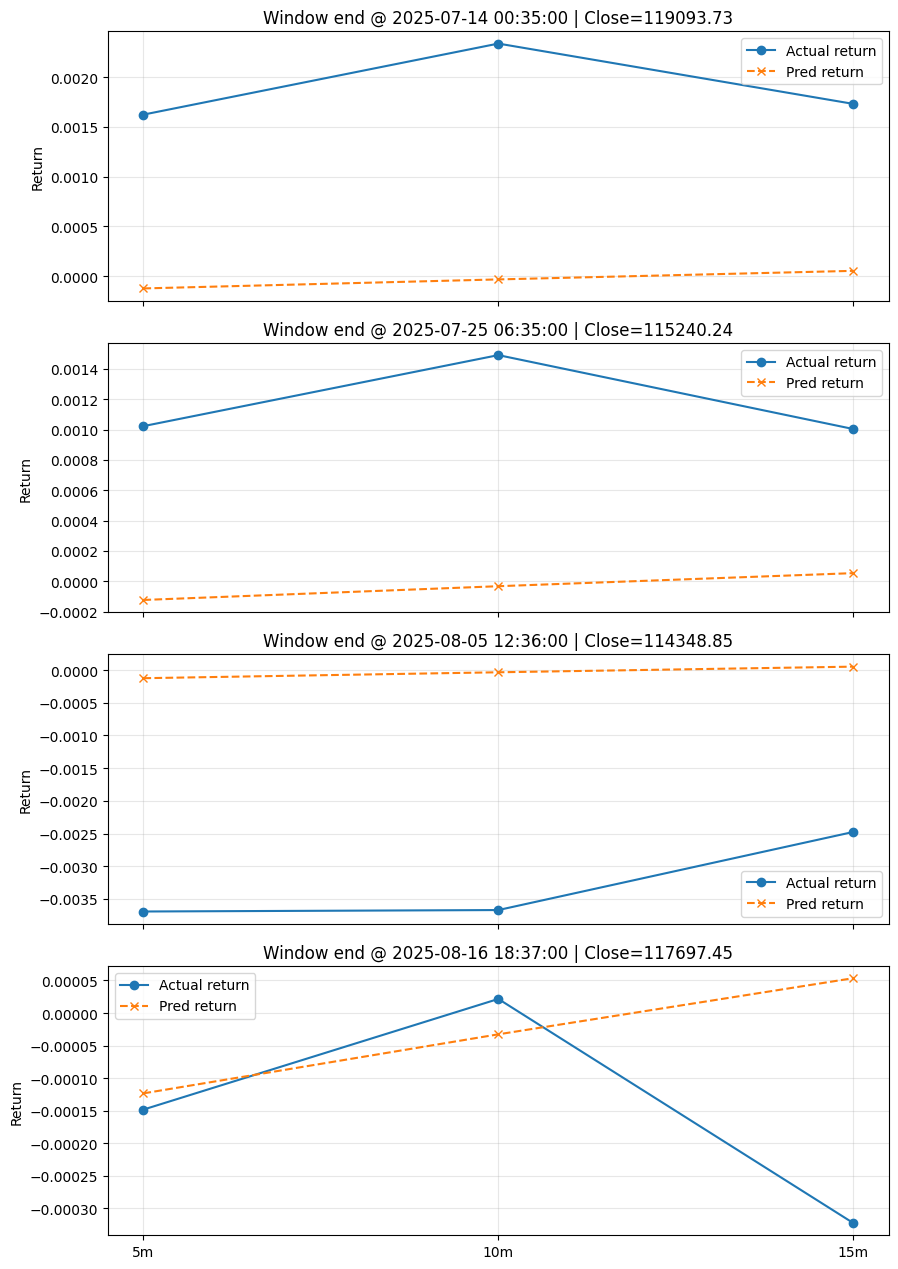

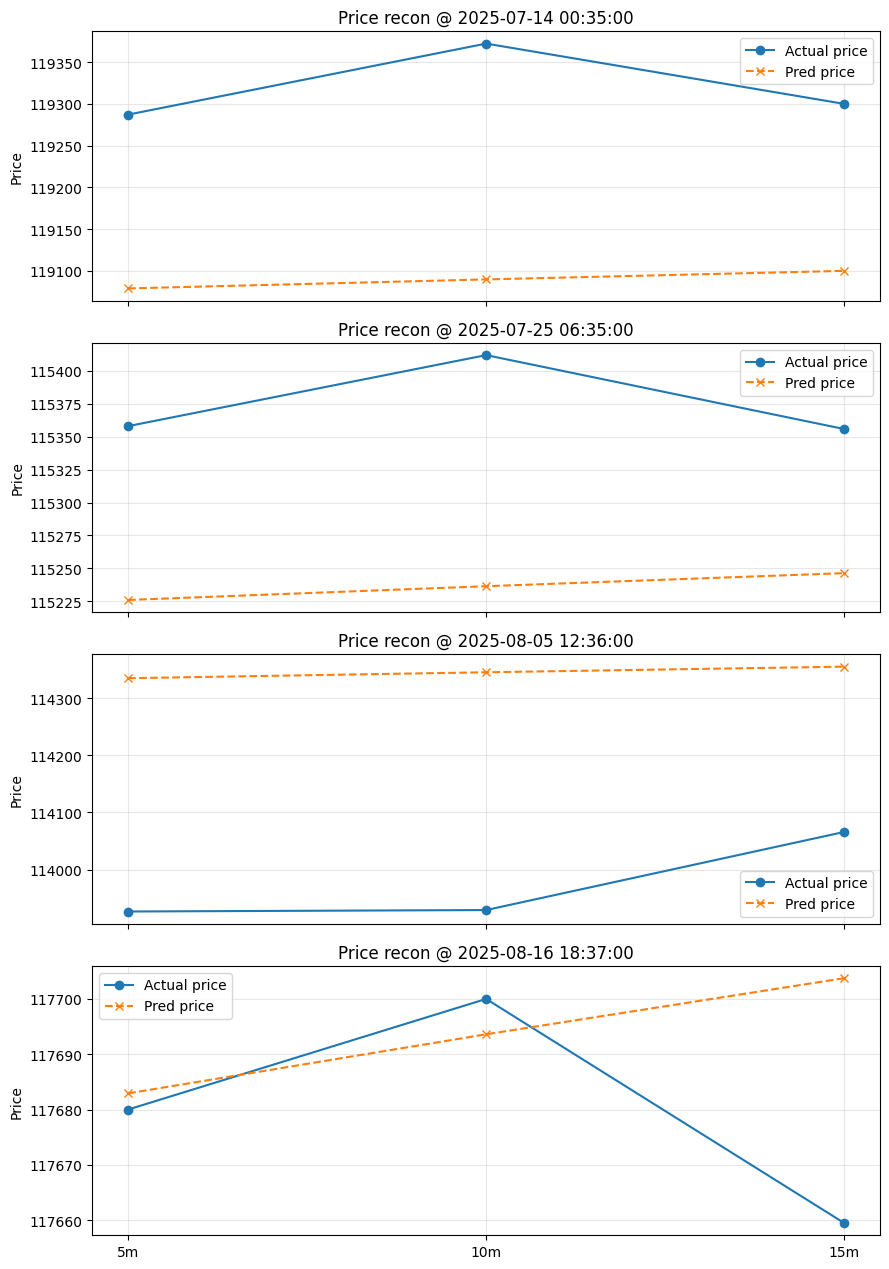

In [62]:
tcn.eval()
y_true_list, y_pred_list = [], []
with torch.no_grad():
    for xb, yb in dl_te:
        yhat = tcn(xb.to(device)).cpu()
        y_true_list.append(yb.cpu())
        y_pred_list.append(yhat)
y_true = torch.cat(y_true_list).numpy()   # [N, H]
y_pred = torch.cat(y_pred_list).numpy()   # [N, H]

# map window-end indices -> timestamps / closes
ends = dl_te.dataset.ends                  # window end positions
times = df_base.loc[idx, 'ts'].values[ends]
closes_now = df_base.loc[idx, 'Close'].values[ends]

# pick a few evenly-spaced samples
H = len(time_periods)
xs = np.arange(H)
picks = np.linspace(0, len(ends)-1, num=min(4, len(ends)), dtype=int)

# returns per horizon
fig, axes = plt.subplots(len(picks), 1, figsize=(9, 3.2*len(picks)), sharex=True)
if len(picks) == 1: axes = [axes]
for ax, i in zip(axes, picks):
    ax.plot(xs, y_true[i], marker='o', label='Actual return')
    ax.plot(xs, y_pred[i], marker='x', linestyle='--', label='Pred return')
    ax.set_xticks(xs, [f'{h}m' for h in time_periods])
    ax.set_title(f'Window end @ {pd.to_datetime(times[i])} | Close={closes_now[i]:.2f}')
    ax.set_ylabel('Return'); ax.grid(True, alpha=0.3); ax.legend()
plt.tight_layout(); plt.show()

# optional: reconstruct prices for the same samples
fig, axes = plt.subplots(len(picks), 1, figsize=(9, 3.2*len(picks)), sharex=True)
if len(picks) == 1: axes = [axes]
for ax, i in zip(axes, picks):
    true_prices = closes_now[i] * (1.0 + y_true[i])
    pred_prices = closes_now[i] * (1.0 + y_pred[i])
    ax.plot(xs, true_prices, marker='o', label='Actual price')
    ax.plot(xs, pred_prices, marker='x', linestyle='--', label='Pred price')
    ax.set_xticks(xs, [f'{h}m' for h in time_periods])
    ax.set_title(f'Price recon @ {pd.to_datetime(times[i])}')
    ax.set_ylabel('Price'); ax.grid(True, alpha=0.3); ax.legend()
plt.tight_layout(); plt.show()

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


   horizon_min       MAE      RMSE       MAPE  Corr
0            5  0.000711  0.001022  43.485649   NaN
1           10  0.000998  0.001421   4.965916   NaN
2           15  0.001225  0.001718   4.282718   NaN


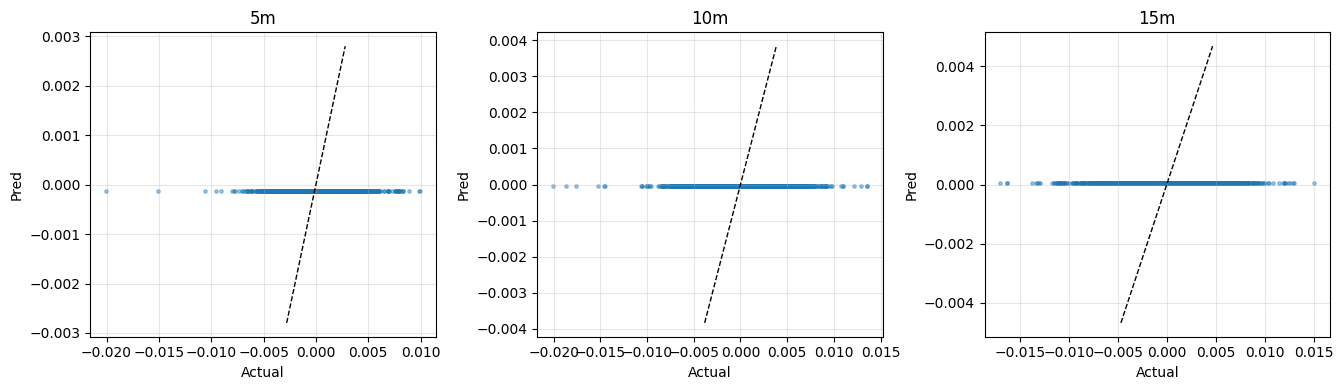

In [63]:
# simple per-horizon metrics
rows=[]
for j, h in enumerate(time_periods):
    yt, yp = y_true[:, j], y_pred[:, j]
    mae = np.mean(np.abs(yt-yp)); rmse = np.sqrt(np.mean((yt-yp)**2))
    mape = np.mean(np.abs(yt-yp)/(np.abs(yt)+1e-8))
    corr = np.corrcoef(yt, yp)[0,1] if len(yt)>1 else np.nan
    rows.append({'horizon_min': h, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'Corr': corr})
print(pd.DataFrame(rows).round(6))

# scatter pred vs actual per horizon
cols = min(3, len(time_periods)); rows = int(np.ceil(len(time_periods)/cols))
fig, axes = plt.subplots(rows, cols, figsize=(4.5*cols, 4*rows))
axes = np.atleast_1d(axes).ravel()
for j, h in enumerate(time_periods):
    ax = axes[j]; yt, yp = y_true[:, j], y_pred[:, j]
    ax.scatter(yt, yp, s=6, alpha=0.4)
    lim = np.percentile(np.abs(np.r_[yt, yp]), 99); lim = max(lim, 1e-4)
    ax.plot([-lim, lim], [-lim, lim], 'k--', lw=1)
    ax.set_title(f'{h}m'); ax.set_xlabel('Actual'); ax.set_ylabel('Pred'); ax.grid(True, alpha=0.3)
for k in range(len(time_periods), len(axes)):
    fig.delaxes(axes[k])
plt.tight_layout(); plt.show()

#### GRU

In [64]:
gru = GRU_RNNRegressor(in_feats, H, hidden=128, layers=2, dropout=0.1)
gru = fit_model(gru, dl_tr, dl_va, device, epochs=60, lr=1e-3, wd=1e-4, patience=8, tag="GRU")

gru_test_metrics, gru_yhat, gru_ytrue = eval_epoch(gru, dl_te, device)
print("GRU test:", {k: round(v,6) for k,v in gru_test_metrics.items()})

GRU training:   0%|          | 0/60 [00:00<?, ?it/s]

GRU test: {'mae': 0.000992, 'rmse': 0.001431, 'mape': 24.842098, 'dir_acc': 0.494092, 'loss': 3e-06}


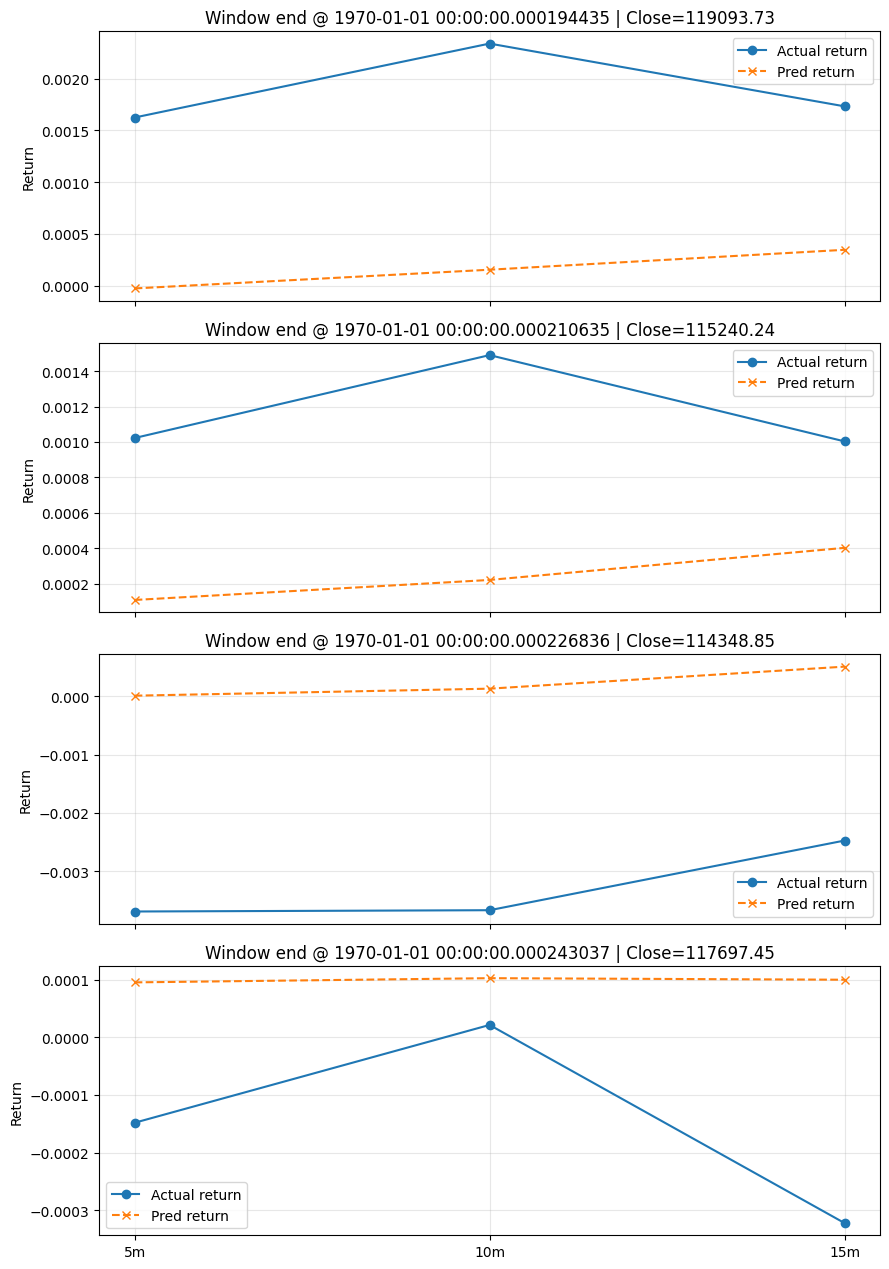

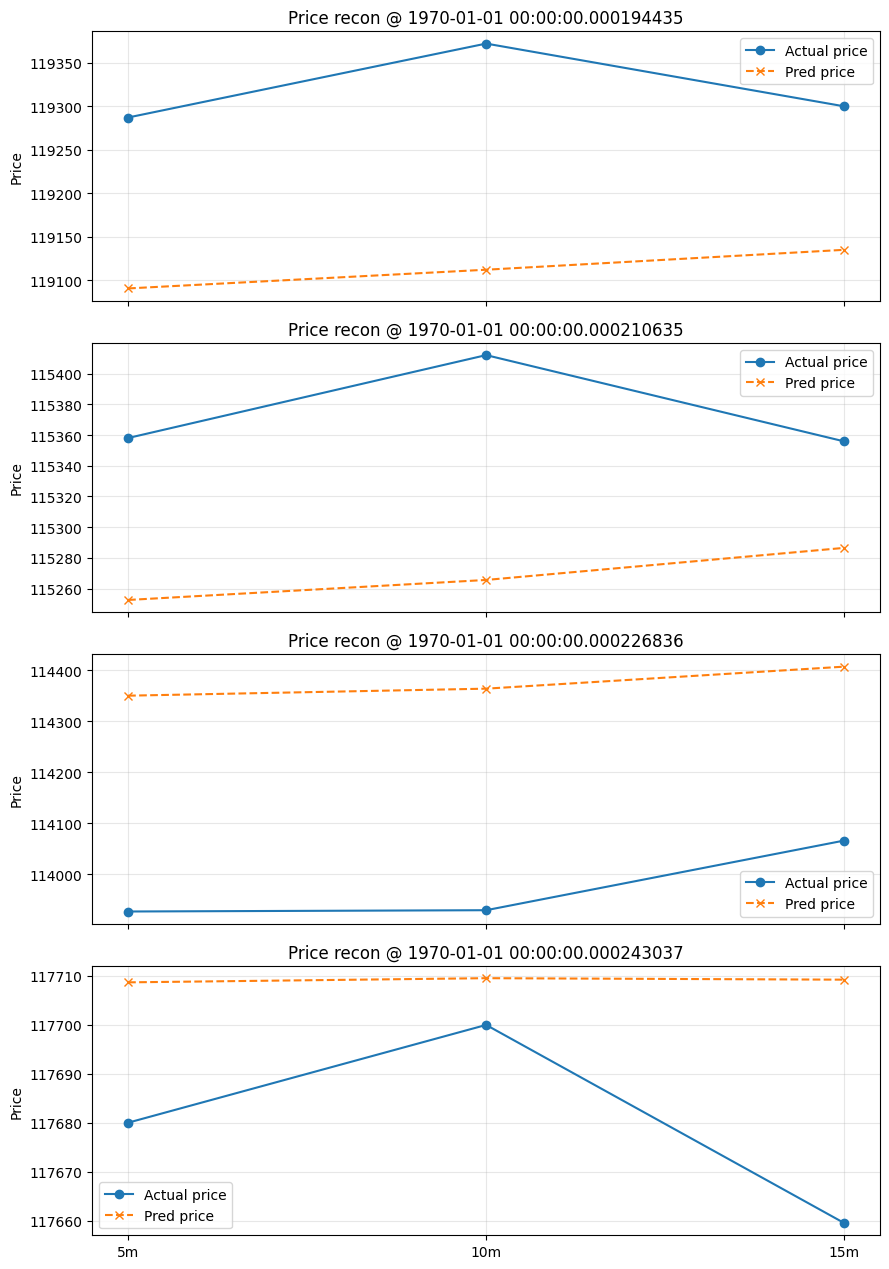

In [65]:
gru.eval()
y_true_list, y_pred_list = [], []
with torch.no_grad():
    for xb, yb in dl_te:
        yhat = gru(xb.to(device)).cpu()
        y_true_list.append(yb.cpu())
        y_pred_list.append(yhat)
y_true = torch.cat(y_true_list).numpy()   # [N, H]
y_pred = torch.cat(y_pred_list).numpy()   # [N, H]

# map window-end indices -> timestamps / closes
ends = dl_te.dataset.ends                  # window end positions
times = np.array(idx)[ends]                # timestamps aligned to prepared frame
closes_now = df_base.loc[idx, 'Close'].values[ends]

# pick a few evenly-spaced samples
H = len(time_periods)
xs = np.arange(H)
picks = np.linspace(0, len(ends)-1, num=min(4, len(ends)), dtype=int)

# returns per horizon
fig, axes = plt.subplots(len(picks), 1, figsize=(9, 3.2*len(picks)), sharex=True)
if len(picks) == 1: axes = [axes]
for ax, i in zip(axes, picks):
    ax.plot(xs, y_true[i], marker='o', label='Actual return')
    ax.plot(xs, y_pred[i], marker='x', linestyle='--', label='Pred return')
    ax.set_xticks(xs, [f'{h}m' for h in time_periods])
    ax.set_title(f'Window end @ {pd.to_datetime(times[i])} | Close={closes_now[i]:.2f}')
    ax.set_ylabel('Return'); ax.grid(True, alpha=0.3); ax.legend()
plt.tight_layout(); plt.show()

# optional: reconstruct prices for the same samples
fig, axes = plt.subplots(len(picks), 1, figsize=(9, 3.2*len(picks)), sharex=True)
if len(picks) == 1: axes = [axes]
for ax, i in zip(axes, picks):
    true_prices = closes_now[i] * (1.0 + y_true[i])
    pred_prices = closes_now[i] * (1.0 + y_pred[i])
    ax.plot(xs, true_prices, marker='o', label='Actual price')
    ax.plot(xs, pred_prices, marker='x', linestyle='--', label='Pred price')
    ax.set_xticks(xs, [f'{h}m' for h in time_periods])
    ax.set_title(f'Price recon @ {pd.to_datetime(times[i])}')
    ax.set_ylabel('Price'); ax.grid(True, alpha=0.3); ax.legend()
plt.tight_layout(); plt.show()

   horizon_min       MAE      RMSE       MAPE      Corr
0            5  0.000712  0.001022  41.644939  0.011745
1           10  0.001013  0.001434  17.771461 -0.015546
2           15  0.001252  0.001744  15.109893  0.014726


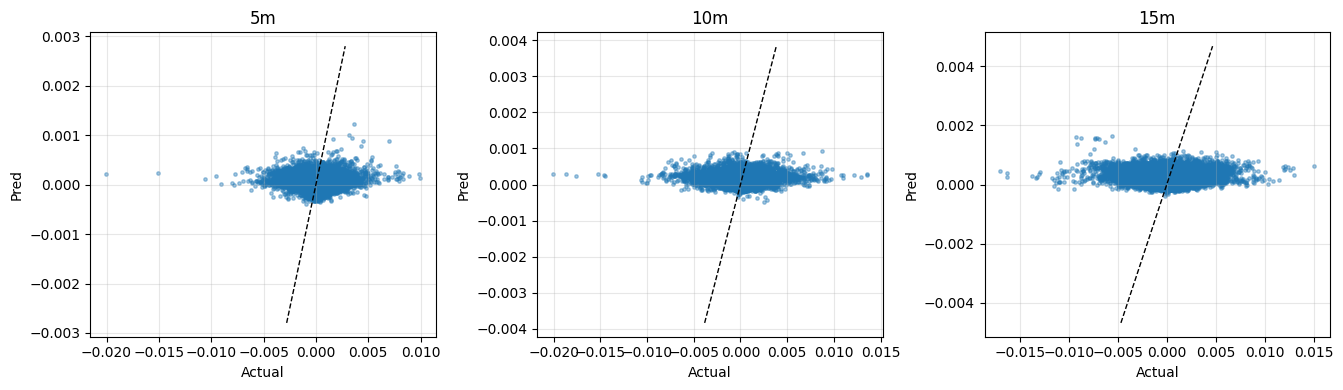

In [66]:
# simple per-horizon metrics
rows=[]
for j, h in enumerate(time_periods):
    yt, yp = y_true[:, j], y_pred[:, j]
    mae = np.mean(np.abs(yt-yp)); rmse = np.sqrt(np.mean((yt-yp)**2))
    mape = np.mean(np.abs(yt-yp)/(np.abs(yt)+1e-8))
    corr = np.corrcoef(yt, yp)[0,1] if len(yt)>1 else np.nan
    rows.append({'horizon_min': h, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'Corr': corr})
print(pd.DataFrame(rows).round(6))

# scatter pred vs actual per horizon
cols = min(3, len(time_periods)); rows = int(np.ceil(len(time_periods)/cols))
fig, axes = plt.subplots(rows, cols, figsize=(4.5*cols, 4*rows))
axes = np.atleast_1d(axes).ravel()
for j, h in enumerate(time_periods):
    ax = axes[j]; yt, yp = y_true[:, j], y_pred[:, j]
    ax.scatter(yt, yp, s=6, alpha=0.4)
    lim = np.percentile(np.abs(np.r_[yt, yp]), 99); lim = max(lim, 1e-4)
    ax.plot([-lim, lim], [-lim, lim], 'k--', lw=1)
    ax.set_title(f'{h}m'); ax.set_xlabel('Actual'); ax.set_ylabel('Pred'); ax.grid(True, alpha=0.3)
for k in range(len(time_periods), len(axes)):
    fig.delaxes(axes[k])
plt.tight_layout(); plt.show()